# Part3 Improvement
## Author: Ji Qi
Functions called in this notebook are defined in the aim2functions.py file. Those functions are mainly wrote by Ji Qi, not directly from packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE
import warnings
from aim2functions import *
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
import os
import sys
sys.path.append("/Users/jiqi/Documents/GitHub/CBB750/")

[nltk_data] Downloading package stopwords to /Users/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Preprocess

In [5]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

# Define a function to perform chi-square test and select top k features
def chi2_feature_selection(X, y, k):
    selector = SelectKBest(score_func=chi2, k=k)
    selector.fit(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_features = X[:, selected_indices]
    
    # Convert selected features to binary values
    selected_features[selected_features > 0] = 1
    
    # Compute contingency table and p-values
    contingency_table = np.vstack([selected_features[y == label].sum(axis=0) for label in np.unique(y)])
    _, p_values, _, _ = chi2_contingency(contingency_table)
    
    return selected_indices, p_values

# Define a function to print classification metrics
def print_classification_metrics(y_true, y_pred, target_names):
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('F1-score: {:.3f}'.format(f1_score(y_true, y_pred, average='weighted')))
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=target_names))


In [ ]:
import pandas as pd

IG_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Patient')
IG_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Clinician')
IG_A = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Auto')

IS_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Clinician')
IS_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Patient')

Emo_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Patient')
Emo_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Clinician')

P_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Clinician')
P_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Patient')

In [ ]:
# Combine IG_P, IG_C, IG_A into one dataframe
IG = pd.concat([IG_P, IG_C, IG_A], axis=0, ignore_index=True)
IG
# Combine IS_C, IS_P into one dataframe
IS = pd.concat([IS_C, IS_P], axis=0, ignore_index=True)

# Combine Emo_P, Emo_C into one dataframe
Emo = pd.concat([Emo_P, Emo_C], axis=0, ignore_index=True)

# Combine P_C, P_P into one dataframe
P = pd.concat([P_C, P_P], axis=0, ignore_index=True)


In [ ]:
# Add labels to each dataframe
IG['Label'] = 'Info Giving'
IS['Label'] = 'Info Seeking'
Emo['Label'] = 'Emotion'
P['Label'] = 'Partnership'

# Combine all dataframes into one dataframe
df = pd.concat([IG, IS, Emo, P], axis=0, ignore_index=True)
# drop the columns that are not needed
df = df.drop(['Unnamed: 2'], axis=1)
# rename the columns

df.columns = ['Message', 'Code', 'Label']
df.loc[:, "Code"][df.loc[:, "Code"] == 'Clinician\nInformation-Giving'] = "Clinician"
df.to_csv('DataMessageLabelCode.csv', index=False)

Number of sentences in transcriptions column: 270
Number of unique words in transcriptions column: 1537
===========Original Categories =======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============Reduced Categories ======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============ Reduced Categories ======================


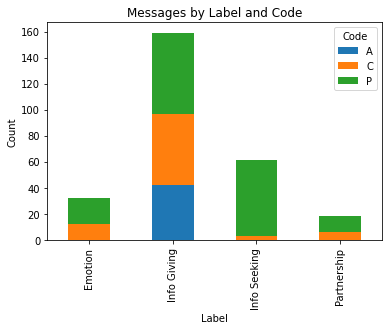

Train_Set_Size:(202, 1000)
Test_Set_Size:(68, 1000)


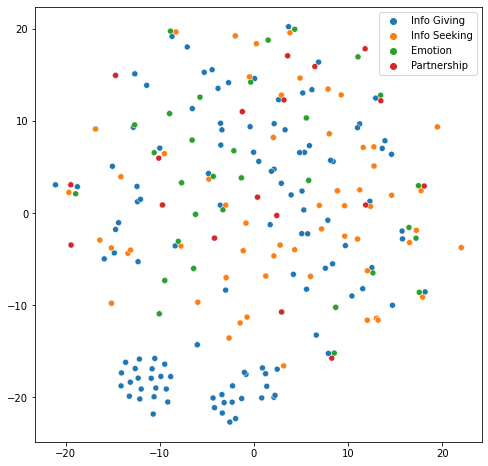

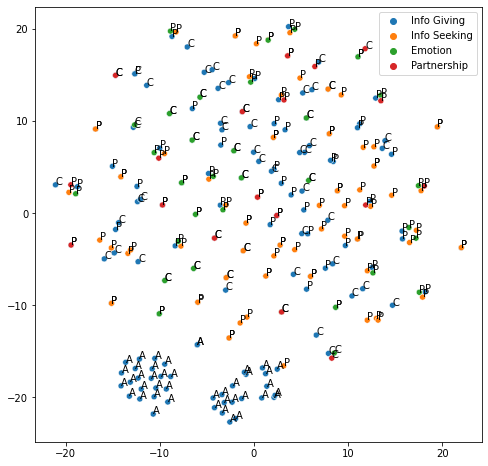

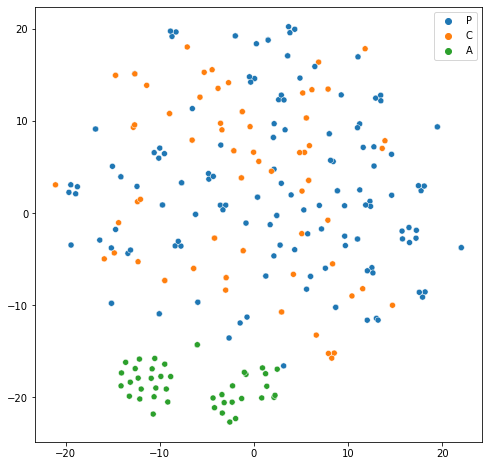

In [2]:
# Read the data
df = pd.read_csv('Data/DataMessageLabelCode.csv')
# Get the number of sentences and words in the data
tfIdfMatrix, data = preprocess_text(df)

# Baseline

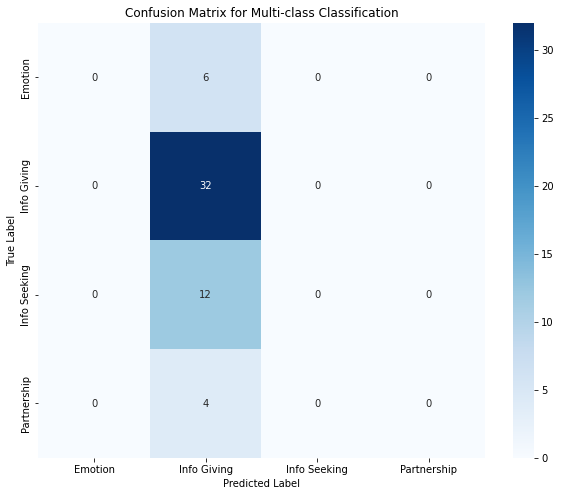

Classification Report:
Accuracy: 0.593
Precision: 0.351
Recall: 0.593
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      1.00      0.74        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [8]:
perform_logistic_regression(data)

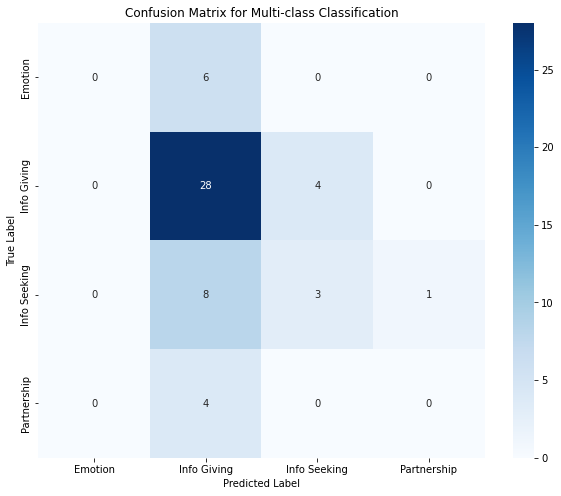

Classification Report:
Accuracy: 0.574
Precision: 0.456
Recall: 0.574
F1-score: 0.496
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.61      0.88      0.72        32
Info Seeking       0.43      0.25      0.32        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.57        54
   macro avg       0.26      0.28      0.26        54
weighted avg       0.46      0.57      0.50        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [9]:
perform_decision_tree_classification(data)

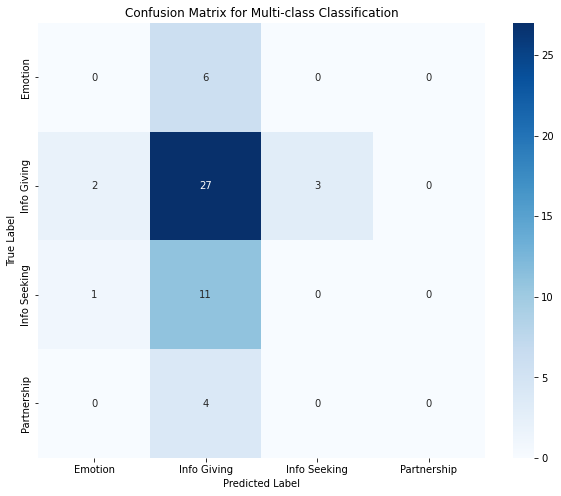

Classification Report:
Accuracy: 0.500
Precision: 0.333
Recall: 0.500
F1-score: 0.400
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.56      0.84      0.68        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.50        54
   macro avg       0.14      0.21      0.17        54
weighted avg       0.33      0.50      0.40        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [10]:
perform_random_forest_classification(data)

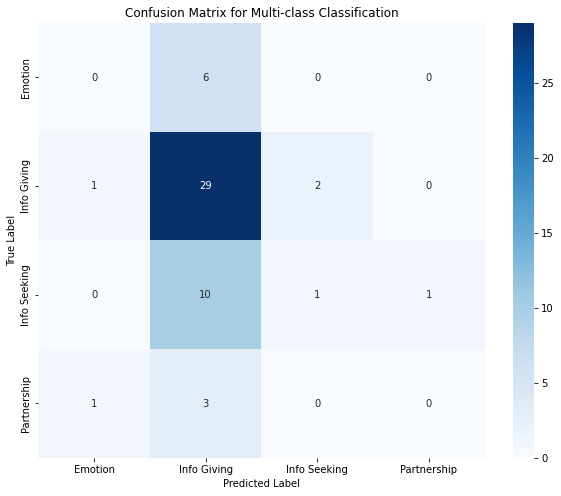

Classification Report:
Accuracy: 0.556
Precision: 0.432
Recall: 0.556
F1-score: 0.459
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.60      0.91      0.72        32
Info Seeking       0.33      0.08      0.13        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.56        54
   macro avg       0.23      0.25      0.21        54
weighted avg       0.43      0.56      0.46        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [11]:
perform_gradient_boosting_classification(data)

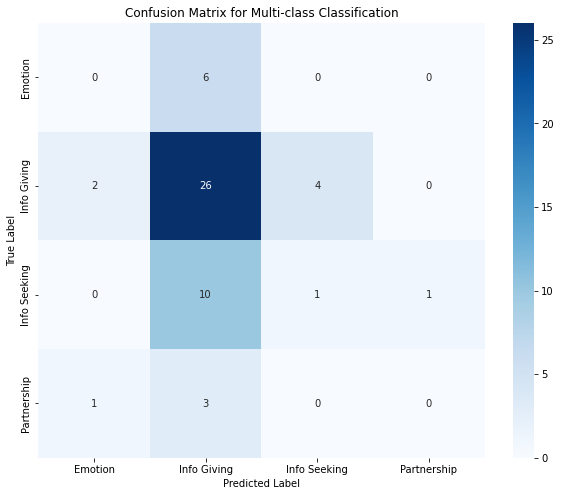

Classification Report:
Accuracy: 0.500
Precision: 0.387
Recall: 0.500
F1-score: 0.426
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.58      0.81      0.68        32
Info Seeking       0.20      0.08      0.12        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.50        54
   macro avg       0.19      0.22      0.20        54
weighted avg       0.39      0.50      0.43        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [12]:
perform_xgboost_classification(data)

# Binary Classification Model

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.630
Precision: 0.642
Recall: 0.630
F1-score: 0.561
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.62      0.94      0.75        32
Non-Info-giving       0.67      0.18      0.29        22

       accuracy                           0.63        54
      macro avg       0.65      0.56      0.52        54
   weighted avg       0.64      0.63      0.56        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

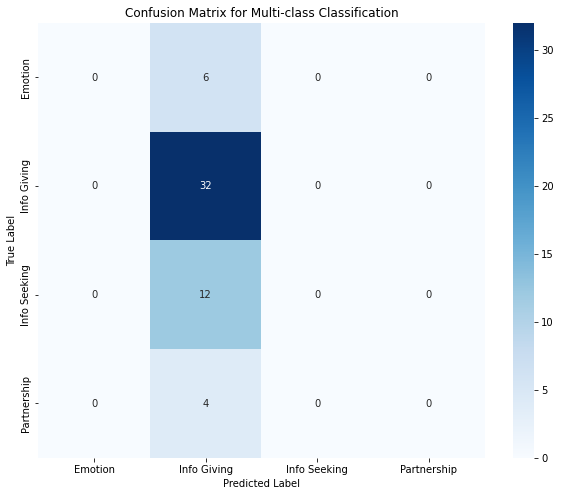

Classification Report:
Accuracy: 0.593
Precision: 0.351
Recall: 0.593
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      1.00      0.74        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 proceed
2 staff
3 trying
4 ok
5 bring
6 coordinate
7 concerned
8 apple
9 symptom
10 amp
11 concluded
12 advise
13 gt
14 type
15 sept
16 coffee
17 coronavirus
18 renewal
19 healthy
20 decreasing
21 ctsim
22 appt
23 stand
24 shot
25 mychart
26 vr
27 pm
28 vimeo
29 luck
30 http
31 took
32 href
33 floor
34 tried
35 supplement
36 message
37 posted
38 think
39 issue
40 sugar
41 pillow
42 mean
43 writing
44 stop
45 heard
46 study
47 lomot

In [ ]:
perform_binary_logistic_regression(data, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.559
Recall: 0.593
F1-score: 0.496
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.60      0.94      0.73        32
Non-Info-giving       0.50      0.09      0.15        22

       accuracy                           0.59        54
      macro avg       0.55      0.51      0.44        54
   weighted avg       0.56      0.59      0.50        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

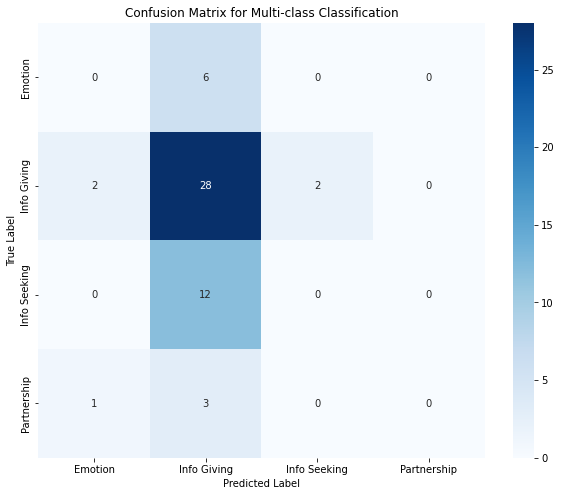

Classification Report:
Accuracy: 0.519
Precision: 0.339
Recall: 0.519
F1-score: 0.410
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.57      0.88      0.69        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.52        54
   macro avg       0.14      0.22      0.17        54
weighted avg       0.34      0.52      0.41        54

Top 200 features:
1 treat
2 sept
3 perscription
4 fall
5 immunotherapy
6 feel
7 supplement
8 uploaded
9 amp
10 vr
11 letter
12 type
13 covid
14 forgot
15 writing
16 com400253143a5b439d1cc
17 date
18 xarelto
19 encouraged
20 update
21 extent
22 authorization
23 android
24 provider
25 http
26 recovery
27 lomotil
28 took
29 morning
30 electively
31 proceed
32 rescheduled
33 trying
34 delaying
35 dawn
36 23rd
37 heart
38 luck
39 dental
40 decided
41 level

In [ ]:
perform_binary_decision_tree_classification(data, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.630
Precision: 0.628
Recall: 0.630
F1-score: 0.576
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.63      0.91      0.74        32
Non-Info-giving       0.62      0.23      0.33        22

       accuracy                           0.63        54
      macro avg       0.63      0.57      0.54        54
   weighted avg       0.63      0.63      0.58        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

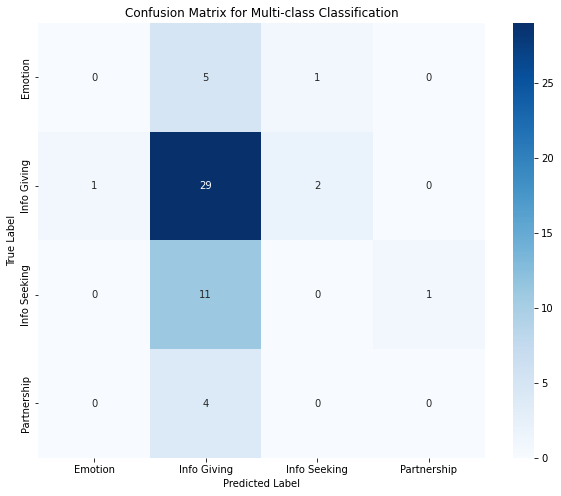

Classification Report:
Accuracy: 0.537
Precision: 0.351
Recall: 0.537
F1-score: 0.424
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      0.91      0.72        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.54        54
   macro avg       0.15      0.23      0.18        54
weighted avg       0.35      0.54      0.42        54

Top 200 features:
1 proceed
2 staff
3 trying
4 ok
5 bring
6 coordinate
7 concerned
8 apple
9 symptom
10 amp
11 concluded
12 advise
13 gt
14 type
15 sept
16 coffee
17 coronavirus
18 renewal
19 healthy
20 decreasing
21 ctsim
22 appt
23 stand
24 shot
25 mychart
26 vr
27 pm
28 vimeo
29 luck
30 http
31 took
32 href
33 floor
34 tried
35 supplement
36 message
37 posted
38 think
39 issue
40 sugar
41 pillow
42 mean
43 writing
44 stop
45 heard
46 study
47 lomot

In [ ]:
perform_binary_random_forest_classification(data, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.574
Precision: 0.514
Recall: 0.574
F1-score: 0.485
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.59      0.91      0.72        32
Non-Info-giving       0.40      0.09      0.15        22

       accuracy                           0.57        54
      macro avg       0.50      0.50      0.43        54
   weighted avg       0.51      0.57      0.48        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

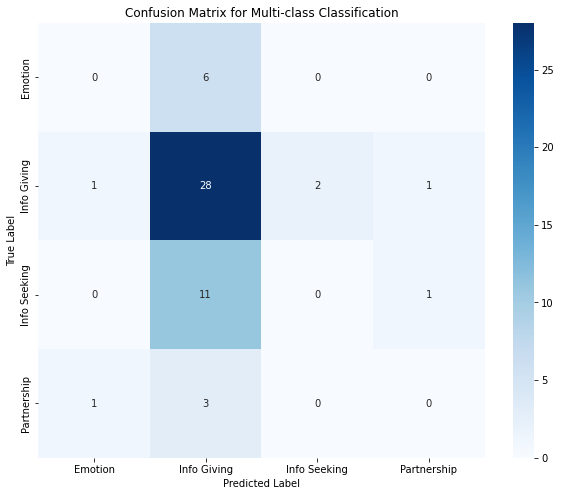

Classification Report:
Accuracy: 0.519
Precision: 0.346
Recall: 0.519
F1-score: 0.415
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.58      0.88      0.70        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.52        54
   macro avg       0.15      0.22      0.18        54
weighted avg       0.35      0.52      0.41        54

Top 200 features:
1 thinner
2 hopefully
3 cif
4 smilow
5 bismol
6 letter
7 date
8 refill
9 recovery
10 stop
11 resume
12 vimeo
13 decreasing
14 rescheduled
15 zofram
16 hope
17 clinical
18 23rd
19 time
20 xarelto
21 sure
22 myelogram
23 contacted
24 wait
25 extent
26 haven
27 forgot
28 decided
29 delaying
30 dept
31 authorization
32 electively
33 heard
34 infected
35 ll
36 team
37 lovanox
38 adjustment
39 pepto
40 coordinate
41 symptom
42 sugar
43 scr

In [ ]:
perform_binary_gradient_boosting_classification(data, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.611
Precision: 0.595
Recall: 0.611
F1-score: 0.562
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.62      0.88      0.73        32
Non-Info-giving       0.56      0.23      0.32        22

       accuracy                           0.61        54
      macro avg       0.59      0.55      0.52        54
   weighted avg       0.60      0.61      0.56        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

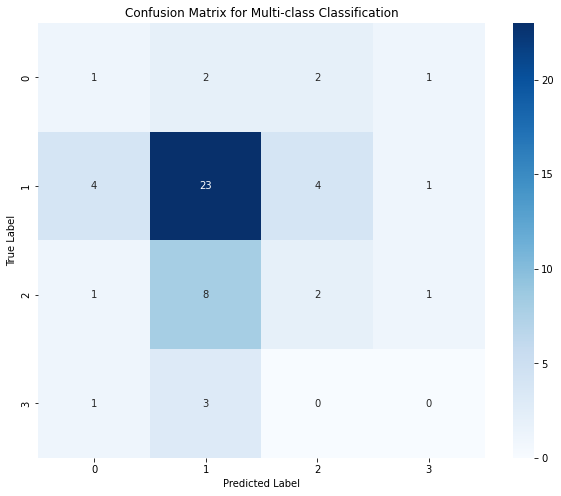

Classification Report:
Accuracy: 0.481
Precision: 0.450
Recall: 0.481
F1-score: 0.462
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.14      0.17      0.15         6
 Info Giving       0.64      0.72      0.68        32
Info Seeking       0.25      0.17      0.20        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.48        54
   macro avg       0.26      0.26      0.26        54
weighted avg       0.45      0.48      0.46        54

Top 200 features:
1 ctsim
2 procedure
3 north
4 delaying
5 vimeo
6 anxious
7 hour
8 street
9 carry
10 writing
11 rescheduled
12 bring
13 crazy
14 shot
15 renewal
16 calcium
17 took
18 visitor
19 saw
20 dept
21 authorization
22 matter
23 supplement
24 12th
25 coffee
26 administrative
27 decreased
28 overlook
29 fall
30 perscription
31 expected
32 insurance
33 treat
34 wait
35 smilow
36 com400253143a5b439d1cc
37 posted
38 concern
39 april
40 decided
41 

In [3]:
clf, selected_features = perform_binary_xgboost_classification(data)

# Use chatgpt to generate more samples

Number of sentences in transcriptions column: 478
Number of unique words in transcriptions column: 939
===========Original Categories =======================
Cat:1 Emotion : 43
Cat:2 Info Giving : 43
Cat:3 Info Seeking : 28
Cat:4 Partnership : 59
============Reduced Categories ======================
Cat:1 Emotion : 43
Cat:2 Info Giving : 43
Cat:3 Info Seeking : 28
Cat:4 Partnership : 59
============ Reduced Categories ======================


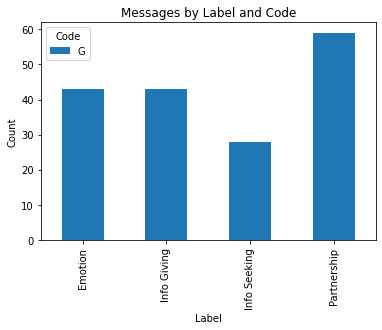

Train_Set_Size:(129, 1000)
Test_Set_Size:(44, 1000)


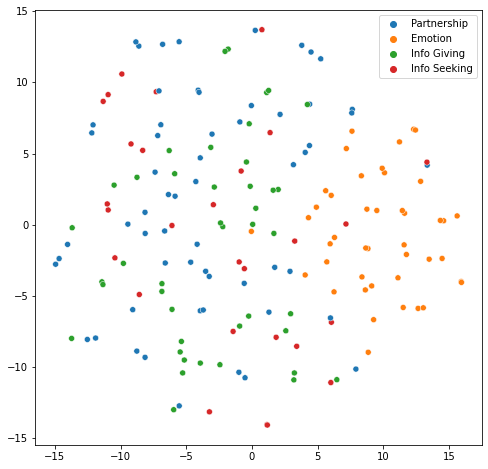

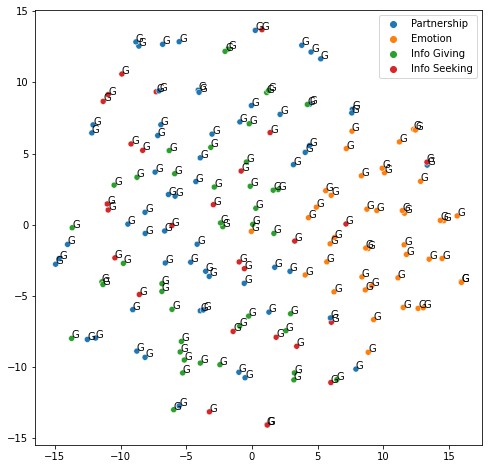

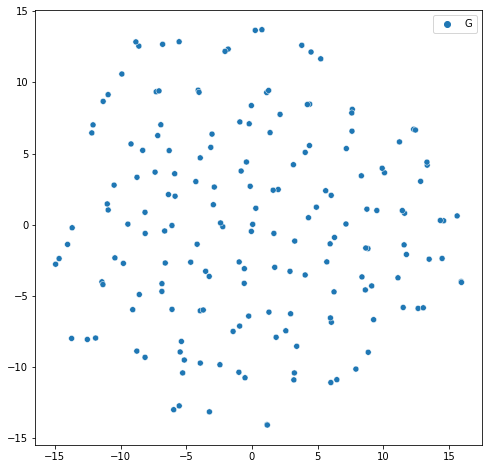

In [3]:
# Use chatgpt to generate more samples
df_gpt = pd.read_csv('Data/GPTMessageLabelCode.csv')
tfidf_matrix_gpt, data_gpt = preprocess_text(df_gpt)

Number of sentences in transcriptions column: 748
Number of unique words in transcriptions column: 2049
===========Original Categories =======================
Cat:1 Emotion : 75
Cat:2 Info Giving : 202
Cat:3 Info Seeking : 89
Cat:4 Partnership : 77
============Reduced Categories ======================
Cat:1 Emotion : 75
Cat:2 Info Giving : 202
Cat:3 Info Seeking : 89
Cat:4 Partnership : 77
============ Reduced Categories ======================


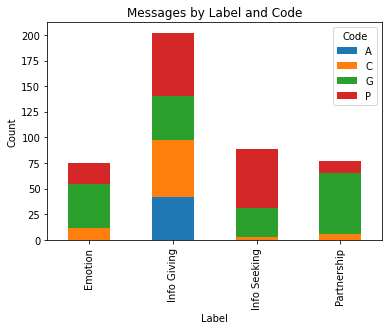

Train_Set_Size:(332, 1000)
Test_Set_Size:(111, 1000)


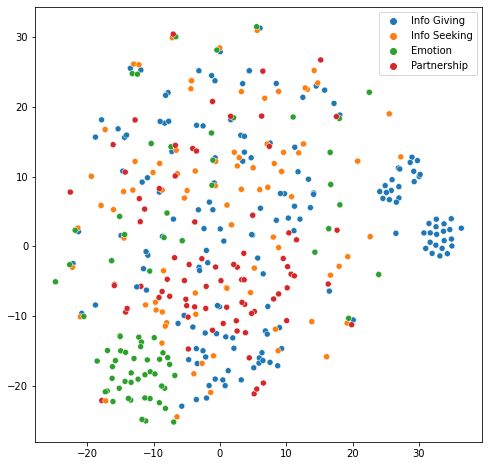

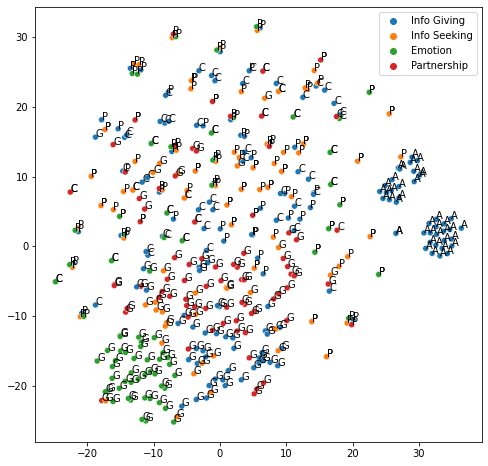

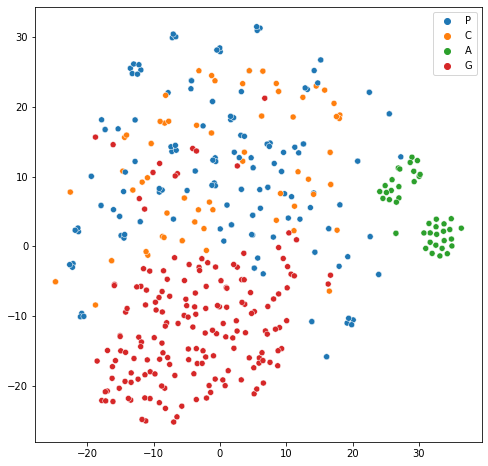

In [6]:
# Combine df and df_combined
df_combined = pd.concat([df, df_gpt], ignore_index=True)
data_combined = pd.concat([data, data_gpt], ignore_index=True)
tfidf_matrix_gpt, data_combined = preprocess_text(df_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.663
Precision: 0.703
Recall: 0.663
F1-score: 0.633
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.79      0.37      0.50        41
Non-Info-giving       0.63      0.92      0.75        48

       accuracy                           0.66        89
      macro avg       0.71      0.64      0.62        89
   weighted avg       0.70      0.66      0.63        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

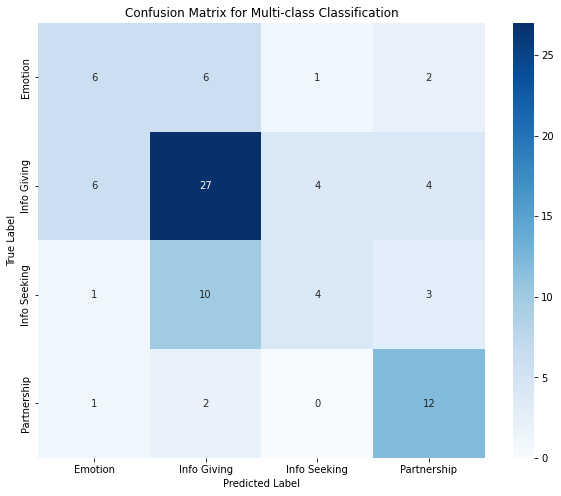

Classification Report:
Accuracy: 0.551
Precision: 0.535
Recall: 0.551
F1-score: 0.531
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.43      0.40      0.41        15
 Info Giving       0.60      0.66      0.63        41
Info Seeking       0.44      0.22      0.30        18
 Partnership       0.57      0.80      0.67        15

    accuracy                           0.55        89
   macro avg       0.51      0.52      0.50        89
weighted avg       0.53      0.55      0.53        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [ ]:
perform_binary_logistic_regression(data_combined, top_k=50)

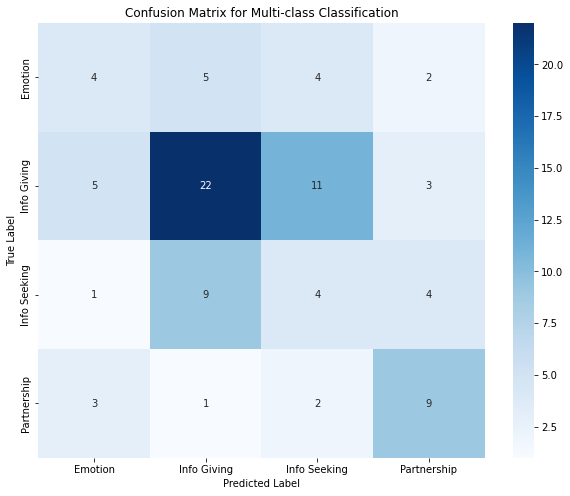

Classification Report:
Accuracy: 0.438
Precision: 0.449
Recall: 0.438
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.31      0.27      0.29        15
 Info Giving       0.59      0.54      0.56        41
Info Seeking       0.19      0.22      0.21        18
 Partnership       0.50      0.60      0.55        15

    accuracy                           0.44        89
   macro avg       0.40      0.41      0.40        89
weighted avg       0.45      0.44      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [ ]:
perform_logistic_regression(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.663
Precision: 0.705
Recall: 0.663
F1-score: 0.654
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.59      0.85      0.70        41
Non-Info-giving       0.80      0.50      0.62        48

       accuracy                           0.66        89
      macro avg       0.70      0.68      0.66        89
   weighted avg       0.70      0.66      0.65        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

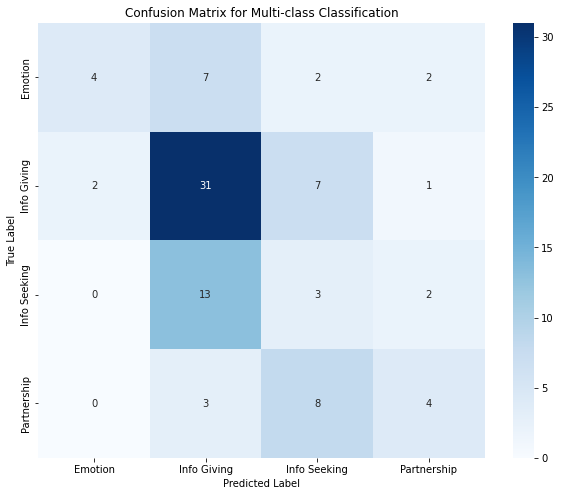

Classification Report:
Accuracy: 0.472
Precision: 0.482
Recall: 0.472
F1-score: 0.453
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.67      0.27      0.38        15
 Info Giving       0.57      0.76      0.65        41
Info Seeking       0.15      0.17      0.16        18
 Partnership       0.44      0.27      0.33        15

    accuracy                           0.47        89
   macro avg       0.46      0.36      0.38        89
weighted avg       0.48      0.47      0.45        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [ ]:
perform_binary_decision_tree_classification(data_combined, top_k=50)

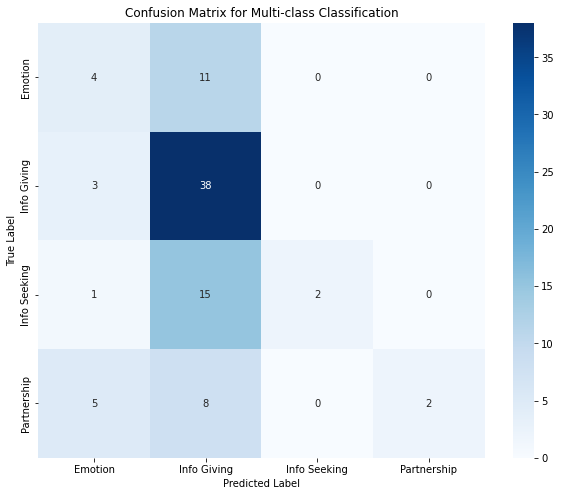

Classification Report:
Accuracy: 0.517
Precision: 0.666
Recall: 0.517
F1-score: 0.438
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.31      0.27      0.29        15
 Info Giving       0.53      0.93      0.67        41
Info Seeking       1.00      0.11      0.20        18
 Partnership       1.00      0.13      0.24        15

    accuracy                           0.52        89
   macro avg       0.71      0.36      0.35        89
weighted avg       0.67      0.52      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [ ]:
perform_decision_tree_classification(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.685
Precision: 0.742
Recall: 0.685
F1-score: 0.675
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.61      0.90      0.73        41
Non-Info-giving       0.86      0.50      0.63        48

       accuracy                           0.69        89
      macro avg       0.73      0.70      0.68        89
   weighted avg       0.74      0.69      0.67        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

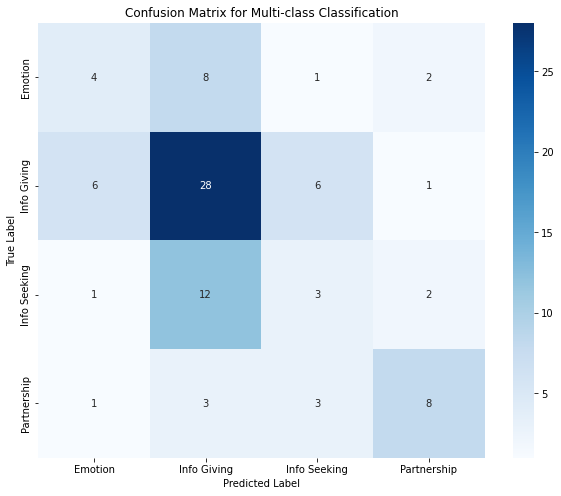

Classification Report:
Accuracy: 0.483
Precision: 0.459
Recall: 0.483
F1-score: 0.466
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.33      0.27      0.30        15
 Info Giving       0.55      0.68      0.61        41
Info Seeking       0.23      0.17      0.19        18
 Partnership       0.62      0.53      0.57        15

    accuracy                           0.48        89
   macro avg       0.43      0.41      0.42        89
weighted avg       0.46      0.48      0.47        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [ ]:
perform_binary_random_forest_classification(data_combined, top_k=50)

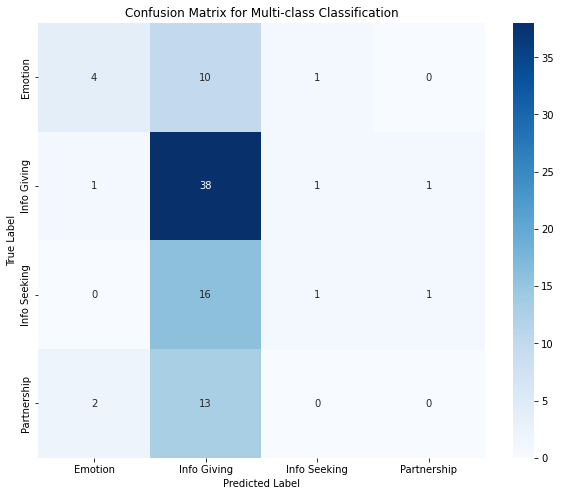

Classification Report:
Accuracy: 0.483
Precision: 0.391
Recall: 0.483
F1-score: 0.377
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.57      0.27      0.36        15
 Info Giving       0.49      0.93      0.64        41
Info Seeking       0.33      0.06      0.10        18
 Partnership       0.00      0.00      0.00        15

    accuracy                           0.48        89
   macro avg       0.35      0.31      0.28        89
weighted avg       0.39      0.48      0.38        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [ ]:
perform_random_forest_classification(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.685
Precision: 0.751
Recall: 0.685
F1-score: 0.652
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.88      0.37      0.52        41
Non-Info-giving       0.64      0.96      0.77        48

       accuracy                           0.69        89
      macro avg       0.76      0.66      0.64        89
   weighted avg       0.75      0.69      0.65        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

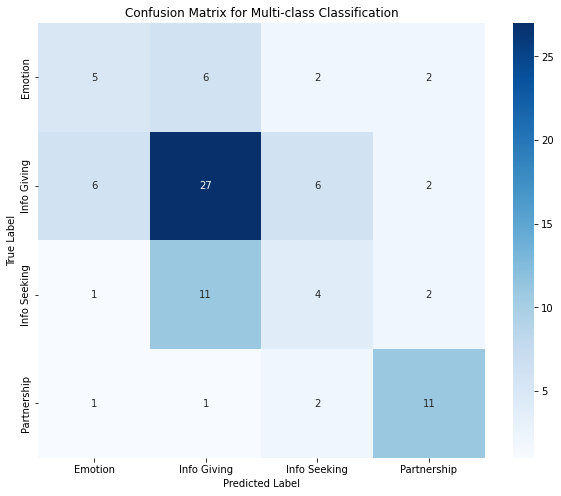

Classification Report:
Accuracy: 0.528
Precision: 0.508
Recall: 0.528
F1-score: 0.516
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.38      0.33      0.36        15
 Info Giving       0.60      0.66      0.63        41
Info Seeking       0.29      0.22      0.25        18
 Partnership       0.65      0.73      0.69        15

    accuracy                           0.53        89
   macro avg       0.48      0.49      0.48        89
weighted avg       0.51      0.53      0.52        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [ ]:
perform_binary_gradient_boosting_classification(data_combined, top_k=50)

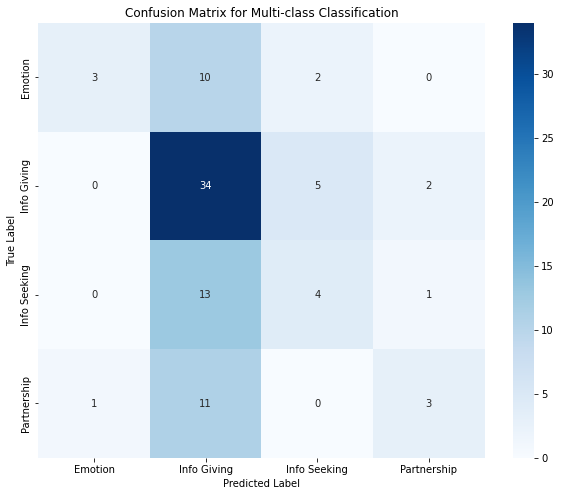

Classification Report:
Accuracy: 0.494
Precision: 0.515
Recall: 0.494
F1-score: 0.445
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.75      0.20      0.32        15
 Info Giving       0.50      0.83      0.62        41
Info Seeking       0.36      0.22      0.28        18
 Partnership       0.50      0.20      0.29        15

    accuracy                           0.49        89
   macro avg       0.53      0.36      0.38        89
weighted avg       0.51      0.49      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [ ]:
perform_gradient_boosting_classification(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.697
Precision: 0.762
Recall: 0.697
F1-score: 0.685
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.61      0.93      0.74        41
Non-Info-giving       0.89      0.50      0.64        48

       accuracy                           0.70        89
      macro avg       0.75      0.71      0.69        89
   weighted avg       0.76      0.70      0.69        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

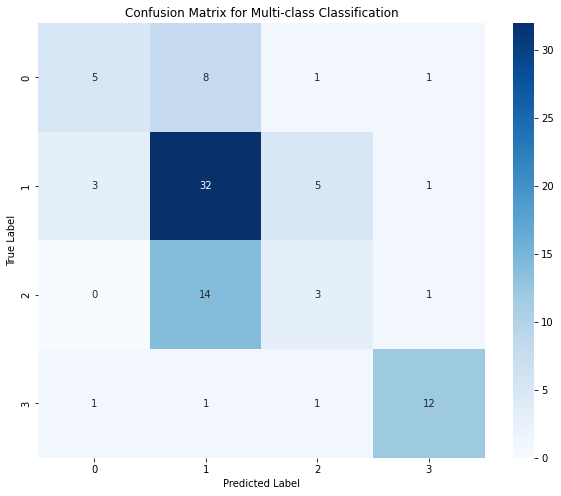

Classification Report:
Accuracy: 0.584
Precision: 0.557
Recall: 0.584
F1-score: 0.556
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.56      0.33      0.42        15
 Info Giving       0.58      0.78      0.67        41
Info Seeking       0.30      0.17      0.21        18
 Partnership       0.80      0.80      0.80        15

    accuracy                           0.58        89
   macro avg       0.56      0.52      0.52        89
weighted avg       0.56      0.58      0.56        89

Top 200 features:
1 challenging
2 happen
3 hear
4 pattern
5 http
6 option
7 lovanox
8 bit
9 food
10 situation
11 overlook
12 manage
13 telemedicine
14 scheduling
15 explore
16 mild
17 generic
18 seek
19 parker
20 street
21 advice
22 assistance
23 received
24 provide
25 info
26 infected
27 north
28 visitor
29 calm
30 adjustment
31 new
32 ctsim
33 moore
34 peterson
35 stressed
36 action
37 com400253143a5b439d1cc
38 extent
39 floor
40 implication
41 shar

In [7]:
perform_binary_xgboost_classification(data_combined)

# Integrated with chatgpt and EDA augmented data

In [4]:
df_eda = pd.read_csv('Data/augmented_data.csv', index_col=0)
df_eda.columns = ['Message', 'Label']
df_eda["Code"] = "EDA"
df_eda = df_eda.loc[list(df_eda.loc[:,"Label"] != "SDM"), :]

Number of sentences in transcriptions column: 338
Number of unique words in transcriptions column: 1715
===========Original Categories =======================
Cat:1 Emotion : 64
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 54
============Reduced Categories ======================
Cat:1 Emotion : 64
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 54
============ Reduced Categories ======================


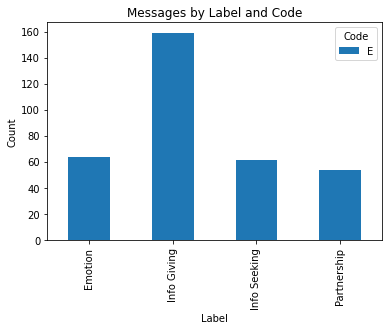

Train_Set_Size:(253, 1000)
Test_Set_Size:(85, 1000)


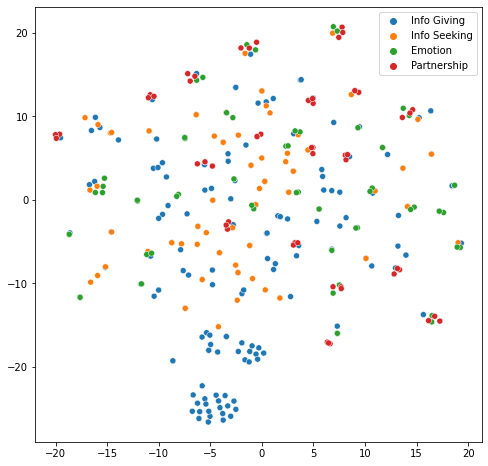

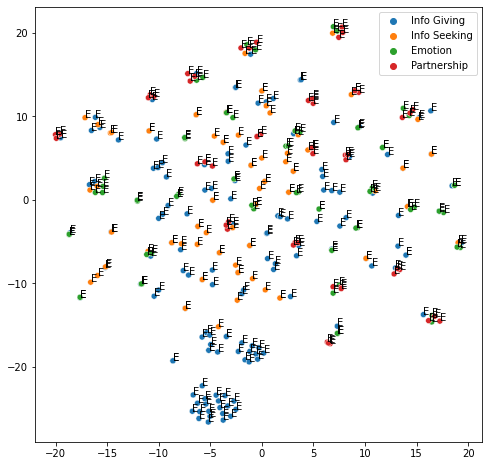

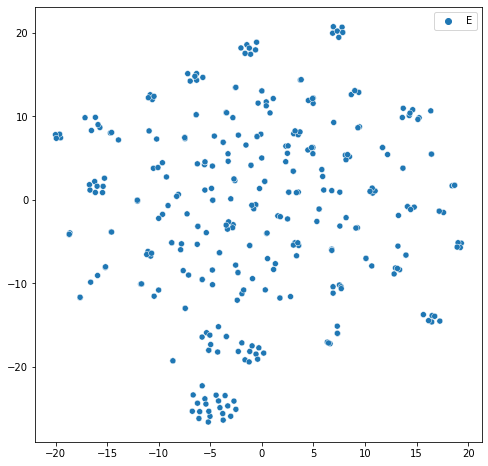

Number of sentences in transcriptions column: 1086
Number of unique words in transcriptions column: 2236
===========Original Categories =======================
Cat:1 Emotion : 139
Cat:2 Info Giving : 361
Cat:3 Info Seeking : 150
Cat:4 Partnership : 131
============Reduced Categories ======================
Cat:1 Emotion : 139
Cat:2 Info Giving : 361
Cat:3 Info Seeking : 150
Cat:4 Partnership : 131
============ Reduced Categories ======================


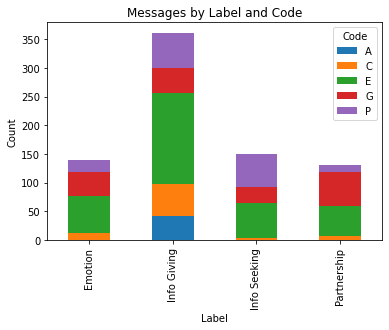

Train_Set_Size:(585, 1000)
Test_Set_Size:(196, 1000)


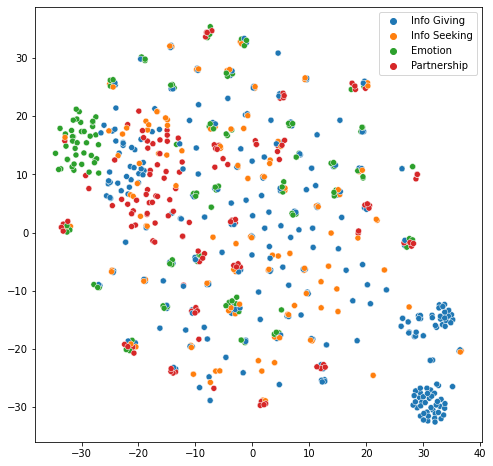

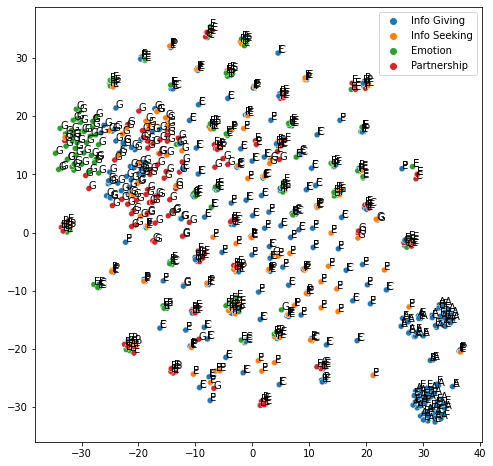

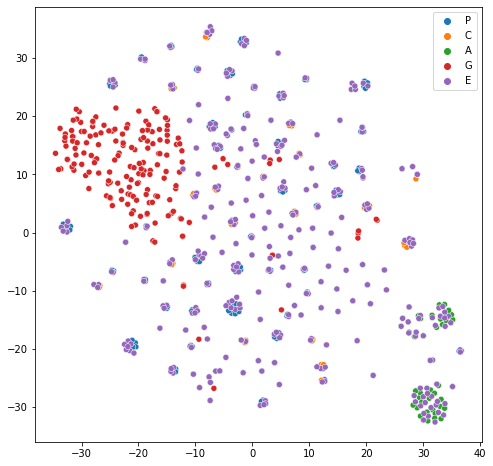

In [7]:
tfIdfMatrix_eda, data_eda = preprocess_text(df_eda)
# Combine df and df_combined
df_final = pd.concat([df_combined, df_eda], ignore_index=True)
data_final = pd.concat([data_combined, data_eda], ignore_index=True)
# replace the values in the specified column
tfIdfMatrix_final, data_final = preprocess_text(df_final)


Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.669
Precision: 0.776
Recall: 0.669
F1-score: 0.621
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.96      0.30      0.46        73
Non-Info-giving       0.62      0.99      0.76        84

       accuracy                           0.67       157
      macro avg       0.79      0.64      0.61       157
   weighted avg       0.78      0.67      0.62       157

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, consult, coronavirus, covid, date, department, dept, devine, encouraged, extent, face, floor, gt, guidance, haven, href, http, infected, information, instructions, lt, mask, md, moved, mychart, north, nt, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits

Performing binary classification for task

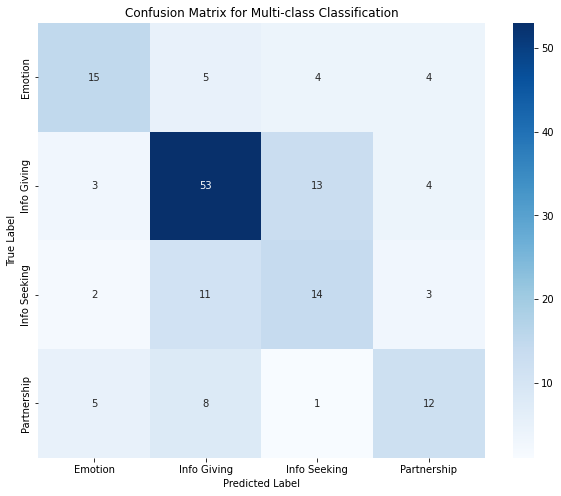

Classification Report:
Accuracy: 0.599
Precision: 0.597
Recall: 0.599
F1-score: 0.597
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.60      0.54      0.57        28
 Info Giving       0.69      0.73      0.71        73
Info Seeking       0.44      0.47      0.45        30
 Partnership       0.52      0.46      0.49        26

    accuracy                           0.60       157
   macro avg       0.56      0.55      0.55       157
weighted avg       0.60      0.60      0.60       157

Top 200 features:
1 scripts
2 1st
3 feeling
4 suitable
5 href
6 bring
7 extent
8 dosage
9 rescheduled
10 support
11 street
12 12th
13 thinner
14 stress
15 com4002532083e3d356236
16 information
17 quite
18 renewal
19 determine
20 xarelto
21 type
22 visiting
23 considering
24 calm
25 vimeo
26 carry
27 greatly
28 eligible
29 date
30 stop
31 coping
32 group
33 zofram
34 fleet
35 enema
36 lomotil
37 vr
38 drs
39 starting
40 pillow
41 coordinate
42 septembe

In [11]:
perform_binary_logistic_regression(data_final, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.675
Precision: 0.798
Recall: 0.675
F1-score: 0.626
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       1.00      0.30      0.46        73
Non-Info-giving       0.62      1.00      0.77        84

       accuracy                           0.68       157
      macro avg       0.81      0.65      0.62       157
   weighted avg       0.80      0.68      0.63       157

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, consult, coronavirus, covid, date, department, dept, devine, encouraged, extent, face, floor, gt, guidance, haven, href, http, infected, information, instructions, lt, mask, md, moved, mychart, north, nt, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits

Performing binary classification for task

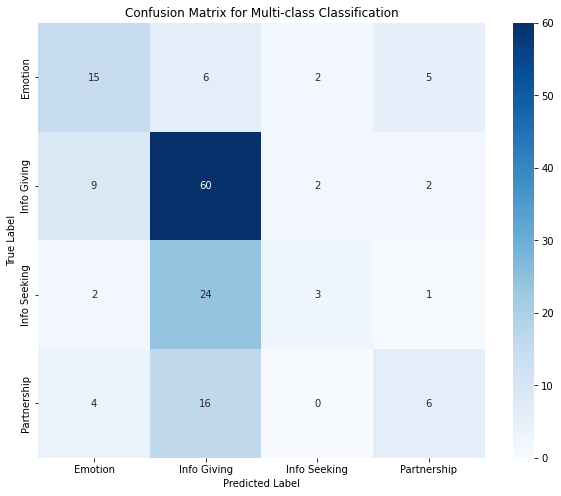

Classification Report:
Accuracy: 0.535
Precision: 0.505
Recall: 0.535
F1-score: 0.485
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.50      0.54      0.52        28
 Info Giving       0.57      0.82      0.67        73
Info Seeking       0.43      0.10      0.16        30
 Partnership       0.43      0.23      0.30        26

    accuracy                           0.54       157
   macro avg       0.48      0.42      0.41       157
weighted avg       0.51      0.54      0.48       157

Top 200 features:
1 scripts
2 1st
3 feeling
4 suitable
5 href
6 bring
7 extent
8 dosage
9 rescheduled
10 support
11 street
12 12th
13 thinner
14 stress
15 com4002532083e3d356236
16 information
17 quite
18 renewal
19 determine
20 xarelto
21 type
22 visiting
23 considering
24 calm
25 vimeo
26 carry
27 greatly
28 eligible
29 date
30 stop
31 coping
32 group
33 zofram
34 fleet
35 enema
36 lomotil
37 vr
38 drs
39 starting
40 pillow
41 coordinate
42 septembe

In [9]:
perform_binary_decision_tree_classification(data_final)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.675
Precision: 0.798
Recall: 0.675
F1-score: 0.626
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       1.00      0.30      0.46        73
Non-Info-giving       0.62      1.00      0.77        84

       accuracy                           0.68       157
      macro avg       0.81      0.65      0.62       157
   weighted avg       0.80      0.68      0.63       157

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, consult, coronavirus, covid, date, department, dept, devine, encouraged, extent, face, floor, gt, guidance, haven, href, http, infected, information, instructions, lt, mask, md, moved, mychart, north, nt, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits

Performing binary classification for task

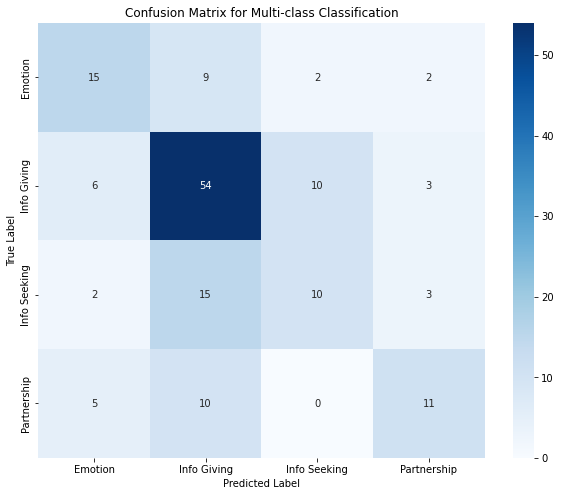

Classification Report:
Accuracy: 0.573
Precision: 0.564
Recall: 0.573
F1-score: 0.562
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.54      0.54      0.54        28
 Info Giving       0.61      0.74      0.67        73
Info Seeking       0.45      0.33      0.38        30
 Partnership       0.58      0.42      0.49        26

    accuracy                           0.57       157
   macro avg       0.55      0.51      0.52       157
weighted avg       0.56      0.57      0.56       157

Top 200 features:
1 scripts
2 1st
3 feeling
4 suitable
5 href
6 bring
7 extent
8 dosage
9 rescheduled
10 support
11 street
12 12th
13 thinner
14 stress
15 com4002532083e3d356236
16 information
17 quite
18 renewal
19 determine
20 xarelto
21 type
22 visiting
23 considering
24 calm
25 vimeo
26 carry
27 greatly
28 eligible
29 date
30 stop
31 coping
32 group
33 zofram
34 fleet
35 enema
36 lomotil
37 vr
38 drs
39 starting
40 pillow
41 coordinate
42 septembe

In [12]:
perform_binary_random_forest_classification(data_final)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.675
Precision: 0.798
Recall: 0.675
F1-score: 0.626
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       1.00      0.30      0.46        73
Non-Info-giving       0.62      1.00      0.77        84

       accuracy                           0.68       157
      macro avg       0.81      0.65      0.62       157
   weighted avg       0.80      0.68      0.63       157

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, consult, coronavirus, covid, date, department, dept, devine, encouraged, extent, face, floor, gt, guidance, haven, href, http, infected, information, instructions, lt, mask, md, moved, mychart, north, nt, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits

Performing binary classification for task

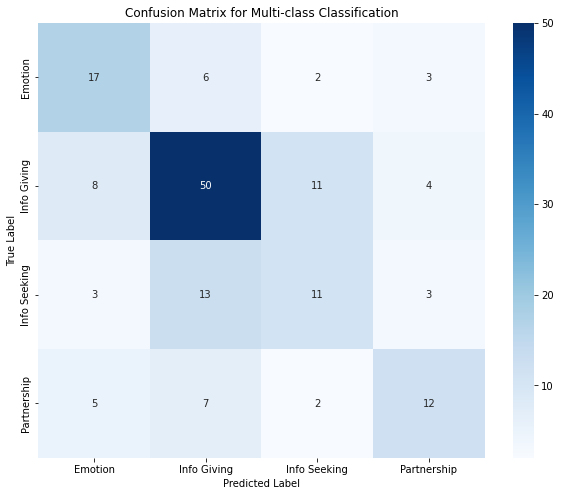

Classification Report:
Accuracy: 0.573
Precision: 0.569
Recall: 0.573
F1-score: 0.569
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.52      0.61      0.56        28
 Info Giving       0.66      0.68      0.67        73
Info Seeking       0.42      0.37      0.39        30
 Partnership       0.55      0.46      0.50        26

    accuracy                           0.57       157
   macro avg       0.54      0.53      0.53       157
weighted avg       0.57      0.57      0.57       157

Top 200 features:
1 scripts
2 1st
3 feeling
4 suitable
5 href
6 bring
7 extent
8 dosage
9 rescheduled
10 support
11 street
12 12th
13 thinner
14 stress
15 com4002532083e3d356236
16 information
17 quite
18 renewal
19 determine
20 xarelto
21 type
22 visiting
23 considering
24 calm
25 vimeo
26 carry
27 greatly
28 eligible
29 date
30 stop
31 coping
32 group
33 zofram
34 fleet
35 enema
36 lomotil
37 vr
38 drs
39 starting
40 pillow
41 coordinate
42 septembe

In [13]:
perform_binary_gradient_boosting_classification(data_final)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.669
Precision: 0.795
Recall: 0.669
F1-score: 0.616
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       1.00      0.29      0.45        73
Non-Info-giving       0.62      1.00      0.76        84

       accuracy                           0.67       157
      macro avg       0.81      0.64      0.61       157
   weighted avg       0.80      0.67      0.62       157

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, consult, coronavirus, covid, date, department, dept, devine, encouraged, extent, face, floor, gt, guidance, haven, href, http, infected, information, instructions, lt, mask, md, moved, mychart, north, nt, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits

Performing binary classification for task

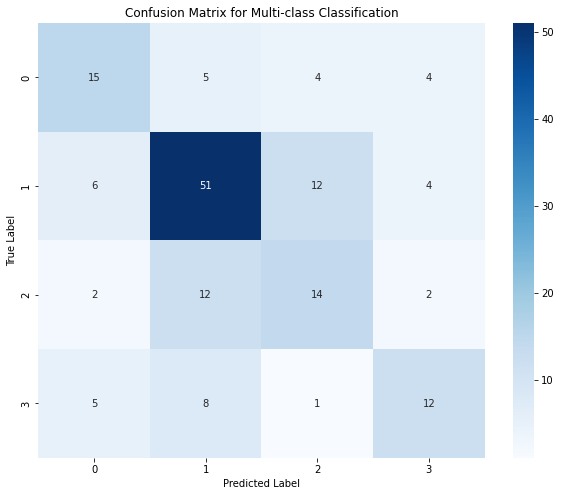

Classification Report:
Accuracy: 0.586
Precision: 0.584
Recall: 0.586
F1-score: 0.584
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.54      0.54      0.54        28
 Info Giving       0.67      0.70      0.68        73
Info Seeking       0.45      0.47      0.46        30
 Partnership       0.55      0.46      0.50        26

    accuracy                           0.59       157
   macro avg       0.55      0.54      0.54       157
weighted avg       0.58      0.59      0.58       157

Top 200 features:
1 scripts
2 1st
3 feeling
4 suitable
5 href
6 bring
7 extent
8 dosage
9 rescheduled
10 support
11 street
12 12th
13 thinner
14 stress
15 com4002532083e3d356236
16 information
17 quite
18 renewal
19 determine
20 xarelto
21 type
22 visiting
23 considering
24 calm
25 vimeo
26 carry
27 greatly
28 eligible
29 date
30 stop
31 coping
32 group
33 zofram
34 fleet
35 enema
36 lomotil
37 vr
38 drs
39 starting
40 pillow
41 coordinate
42 septembe

In [14]:
perform_binary_xgboost_classification(data_final)